In [10]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
# Load dataset
file_path = 'SiO2_dataset.xlsx'
data = pd.read_excel(file_path)

# Separate features and target
X = data.iloc[:, 4:24]
y = data.iloc[:, 24]

# IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mask = (y >= lower_bound) & (y <= upper_bound)
X = X[mask]
y = y[mask]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Define base model for feature selection
model = xgb.XGBRegressor(colsample_bytree=0.8, eta=0.04, max_depth=8, n_estimators=250, subsample=0.7)

# Feature selection using RFECV
rfecv = RFECV(estimator=model, step=1, cv=10, min_features_to_select=1)
rfecv = rfecv.fit(X, y)

# Select features
selected_features = X.columns[rfecv.support_]
X_new = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=12)

# Custom SMOTE for regression
def smote_regression(X, y, k=5, n_samples=800, random_state=12):
    X = np.array(X)
    y = np.array(y)
    np.random.seed(random_state)
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X)
    neighbors_idx = nn.kneighbors(X, return_distance=False)[:, 1:]
    X_resampled = np.zeros((n_samples, X.shape[1]))
    y_resampled = np.zeros(n_samples)

    for i in range(n_samples):
        base_idx = np.random.randint(0, X.shape[0])
        if neighbors_idx[base_idx].size == 0:
            continue
        neighbor_idx = np.random.choice(neighbors_idx[base_idx])
        lam = np.random.rand()
        X_resampled[i] = X[base_idx] + lam * (X[neighbor_idx] - X[base_idx])
        y_resampled[i] = y[base_idx] + lam * (y[neighbor_idx] - y[base_idx])

    X_combined = np.vstack((X, X_resampled))
    y_combined = np.concatenate((y, y_resampled))
    return X_combined, y_combined

# Apply SMOTE
X_train, y_train = smote_regression(X_train, y_train, k=5, n_samples=800, random_state=12)
# Data standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test.values)
X_test = pd.DataFrame(X_test, columns=X_new.columns)
# Train 
model2 = xgb.XGBRegressor(
    colsample_bytree=0.6, eta=0.01, gamma=0.1, max_depth=6,
    min_child_weight=10, n_estimators=600,
    reg_alpha=0.7, reg_lambda=1.5, subsample=0.7)
model2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

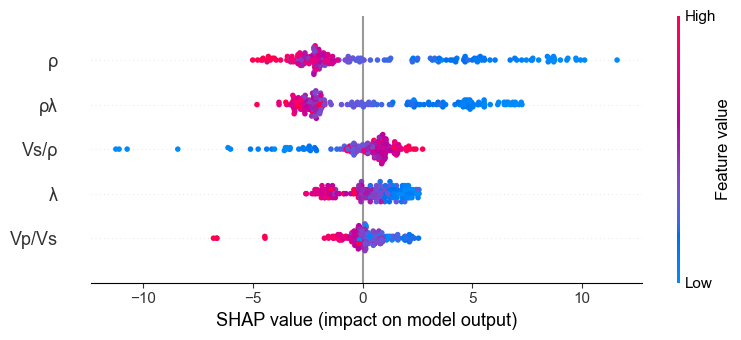

In [12]:
# SHAP feature importance analysis
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)
matplotlib.rcParams['font.family'] = 'Arial'
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="dot", show=False)
plt.savefig("shap_summary_plot.svg", format="svg",  bbox_inches="tight")
plt.savefig("shap_summary_plot.jpg", format="jpg", dpi=300,  bbox_inches="tight")
plt.show()

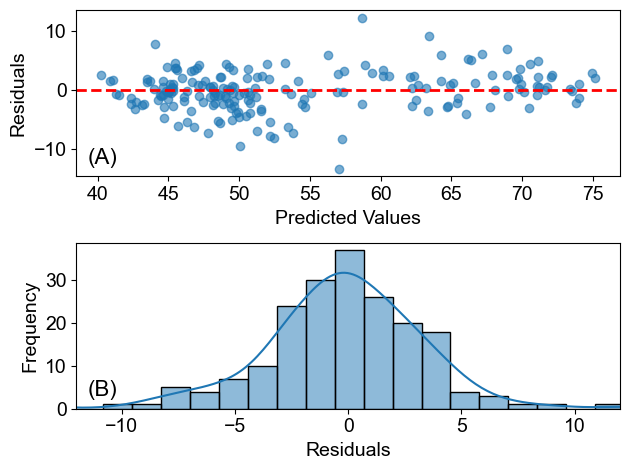

In [13]:
# Prediction and residual analysis
y_pred = model2.predict(X_test)
residuals = y_test - y_pred

# Residuals vs Predicted values plot
plt.subplot(2,1,1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.rcParams['font.family'] = 'Arial'
ftsz = 14
plt.xlabel('Predicted Values', fontsize=ftsz)
plt.ylabel('Residuals', fontsize=ftsz)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.text(0.02, 0.05, '(A)', fontsize=ftsz+2, transform=plt.gca().transAxes, verticalalignment='bottom')

# Residual distribution histogram
plt.subplot(2,1,2)
plt.rcParams['font.family'] = 'Arial'
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel('Residuals', fontsize=ftsz)
plt.ylabel('Frequency', fontsize=ftsz)
plt.xticks(fontsize=ftsz)
plt.yticks(fontsize=ftsz)
plt.xlim(-12, 12)
plt.text(0.02, 0.05, '(B)', fontsize=ftsz+2, transform=plt.gca().transAxes, verticalalignment='bottom')
plt.tight_layout()
plt.savefig(f'Residual Analysis and Distribution.svg', format='svg', bbox_inches='tight')
plt.savefig(f'Residual Analysis and Distribution.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()